![JohnSnowLabs](https://nlp.johnsnowlabs.com/assets/images/logo.png)

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/JohnSnowLabs/spark-nlp-workshop/blob/master/legal-nlp/04.5.Classifying_with_WindowSplitting.ipynb)

# **Splitting with Contextual Window Embeddings**


#🎬 Installation

In [ ]:
! pip install -q johnsnowlabs

##🔗 Automatic Installation
Using my.johnsnowlabs.com SSO

In [ ]:
from johnsnowlabs import nlp, legal

# nlp.install(force_browser=True)

##🔗 Manual downloading
If you are not registered in my.johnsnowlabs.com, you received a license via e-email or you are using Safari, you may need to do a manual update of the license.

- Go to my.johnsnowlabs.com
- Download your license
- Upload it using the following command

In [ ]:
from google.colab import files
print('Please Upload your John Snow Labs License using the button below')
license_keys = files.upload()

- Install it

In [ ]:
nlp.install()

#📌 Starting

In [ ]:
spark = nlp.start()

##📃 Sentence Splitting with Contextual Window Embeddings
Classifiers, in order to properly manage the text length, require to split big documents into smaller chunks. This can be done at sentence, paragraph, section or page level.

However, after splitting, the Classifier will only see the splits, and the rest of the text becomes out of reach for them to be taken into account.

This creates several issues:

1️⃣- Small splits may not have a meaning of their own if not combined with the surroundings.

2️⃣- Splits may be ambiguous, and disambiguation may only happen taking into account the surroundings.

Fortunately, `WindowedSentenceModel` can help to provide some context from the surroundings.

# Comparing Classification of isolated sentences with contexualized

First, let's take a document and split it by sentences. Then, we are going to run a classifier and see the results.

In [5]:
!wget https://raw.githubusercontent.com/JohnSnowLabs/spark-nlp-workshop/master/legal-nlp/data/mnda_example.txt

--2023-04-25 09:44:06--  https://raw.githubusercontent.com/JohnSnowLabs/spark-nlp-workshop/master/legal-nlp/data/mnda_example.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10836 (11K) [text/plain]
Saving to: ‘mnda_example.txt’

mnda_example.txt    100%[===================>]  10.58K  --.-KB/s    in 0s      

2023-04-25 09:44:06 (75.9 MB/s) - ‘mnda_example.txt’ saved [10836/10836]



In [6]:
!head mnda_example.txt

1  
MUTUAL NONDISCLOSURE AGREEMENT  
This Mutual Nondisclosure Agreement (the “Agreement”) is made on _________ (“Effective  
Date”) by and between:  
(1) John Snow Labs, a Delaware corporation, registered at 16192 Coastal Highway,  
Lewes, Delaware 19958 (“John Snow Labs”), and   
(2) Achiles, S.L, a Spanish corporation, registered at Gran Via, 2º floor, Offices 9
and 10.(“Company”),  
(each a “party” and together the “parties”).  
Recitals:  


This is an NDA text. We have a classifier for it which identifies which clause the text belongs to.

However, it works much better with more text, so Context Windows will come in handy. Let's see them in action.

## Sentence splitting

Let's get some sentences

In [113]:
with open('mnda_example.txt', 'r') as f:
  text = f.read()

df = spark.createDataFrame([[text]]).toDF("text")

Let's create first just a Sentence Splitting pipeline

In [116]:
doc_assembler = nlp.DocumentAssembler()\
  .setInputCol("text")\
  .setOutputCol("document")

sentence_detector = nlp.SentenceDetector()\
  .setInputCols(["document"])\
  .setOutputCol("isolated_sentence")

sentence_pipeline = nlp.Pipeline(stages=[doc_assembler, sentence_detector])

sentence_pipeline_model = sentence_pipeline.fit(df)

sentence_pipeline_lp = nlp.LightPipeline(sentence_pipeline_model)

In [117]:
from pyspark.sql import functions as F

isolated_sentences = sentence_pipeline_lp.annotate(text)['isolated_sentence'][:25]
isolated_sentences

['1  \nMUTUAL NONDISCLOSURE AGREEMENT  \nThis Mutual Nondisclosure Agreement (the “Agreement”) is made on _________ (“Effective  \nDate”) by and between:  \n(1) John Snow Labs, a Delaware corporation, registered at 16192 Coastal Highway,  \nLewes, Delaware 19958 (“John Snow Labs”), and   \n(2) Achiles, S.L, a Spanish corporation, registered at Gran Via, 2º floor, Offices 9\nand 10.(“Company”),  \n(each a “party” and together the “parties”).',
 'Recitals:  \nJohn Snow Labs and Company intend to explore the possibility of a business relationship  \nbetween each other, whereby each party (“Discloser”) may disclose sensitive information to the  \nother party (“Recipient”).',
 'The parties agree as follows:',
 '1. Definition.',
 '1.1 The term “Confidential Information” means, to the extent previously, presently or  \nsubsequently disclosed by or for Discloser to Recipient (whether in writing, orally or by  \nanother means), all financial, business, economic, legal, competitively sensitive a

Let's store the embeddings in a separate object to use it for classification purposes

## Now, let's see our classifier in action with those splits

In [121]:
embeddings = nlp.UniversalSentenceEncoder.pretrained()\
                    .setInputCols(["document"])\
                    .setOutputCol("embeddings")

classifier = nlp.MultiClassifierDLModel.pretrained("legmulticlf_mnda_sections_paragraph_other", "en", "legal/models")\
                    .setInputCols(["embeddings"])\
                    .setOutputCol("label")

prediction_pipeline = nlp.Pipeline(stages=[doc_assembler, embeddings, classifier])

prediction_model = prediction_pipeline.fit(df)

prediction_lp = nlp.LightPipeline(prediction_model)

tfhub_use download started this may take some time.
Approximate size to download 923.7 MB
[OK!]
legmulticlf_mnda_sections_paragraph_other download started this may take some time.
Approximate size to download 12.7 MB
[OK!]


Now, let's create a dataframe where we will store the sentences and the labels to compare the different methods

In [122]:
import pandas as pd

comparison_table = []

for s in isolated_sentences:
  label = prediction_lp.annotate(s)['label']

  if len(label) == 0:
    label = ['OTHER']
  comparison_table.append(        (s, label)   )

comparison_table_df = pd.DataFrame(comparison_table, columns=['sentence', 'label_no_context'])

In [123]:
comparison_table_df

,sentence,label_no_context
0,1 \nMUTUAL NONDISCLOSURE AGREEMENT \nThis Mu...,[NAMES_OF_PARTIES]
1,Recitals: \nJohn Snow Labs and Company intend...,[PREAMBLE]
2,The parties agree as follows:,[TERMINATION]
3,1. Definition.,[DEF_OF_CONF_INFO]
4,"1.1 The term “Confidential Information” means,...",[DEF_OF_CONF_INFO]
5,1.2 Confidential Information shall not include...,[OTHER]
6,(a) was rightfully known to Recipient without...,[OTHER]
7,(b) is rightfully disclosed to Recipient with...,[OTHER]
8,(c) is or becomes generally known to the publ...,[EXCEPTIONS]
9,or,[OTHER]


# Now, let's use Context Windows.
Context windows give to each sentence, a context of ```[-n, +n]``` so that the model cna classify them with more information.

```n``` is a number of sentences which is configurable.

In [131]:
from johnsnowlabs import legal

context_window = legal.WindowedSentenceModel()\
                    .setInputCols(["isolated_sentence"])\
                    .setOutputCol("window")\
                    .setWindowSize(1)

window_splitting_pipeline = nlp.Pipeline(stages=[doc_assembler, sentence_detector, context_window])

window_splitting_model = window_splitting_pipeline.fit(df)

window_splitting_lp = nlp.LightPipeline(window_splitting_model)

In [132]:
from pyspark.sql import functions as F

windows = window_splitting_lp.annotate(text)['window'][:25]
windows

['1  \nMUTUAL NONDISCLOSURE AGREEMENT  \nThis Mutual Nondisclosure Agreement (the “Agreement”) is made on _________ (“Effective  \nDate”) by and between:  \n(1) John Snow Labs, a Delaware corporation, registered at 16192 Coastal Highway,  \nLewes, Delaware 19958 (“John Snow Labs”), and   \n(2) Achiles, S.L, a Spanish corporation, registered at Gran Via, 2º floor, Offices 9\nand 10.(“Company”),  \n(each a “party” and together the “parties”). Recitals:  \nJohn Snow Labs and Company intend to explore the possibility of a business relationship  \nbetween each other, whereby each party (“Discloser”) may disclose sensitive information to the  \nother party (“Recipient”).',
 '1  \nMUTUAL NONDISCLOSURE AGREEMENT  \nThis Mutual Nondisclosure Agreement (the “Agreement”) is made on _________ (“Effective  \nDate”) by and between:  \n(1) John Snow Labs, a Delaware corporation, registered at 16192 Coastal Highway,  \nLewes, Delaware 19958 (“John Snow Labs”), and   \n(2) Achiles, S.L, a Spanish corpo

And now, let's classify the sentences with their window, to compare the impact of them in an isolated way from the context:

In [135]:
window_labels = []
for w in windows:
  label = prediction_lp.annotate(w)['label']
  if len(label) == 0:
    label = ['OTHER']
  window_labels.append(label)

## Now, let's visualize the difference!

In [136]:
comparison_table_df['label_context'] = window_labels
comparison_table_df

,sentence,label_no_context,label_context
0,1 \nMUTUAL NONDISCLOSURE AGREEMENT \nThis Mu...,[NAMES_OF_PARTIES],[NAMES_OF_PARTIES]
1,Recitals: \nJohn Snow Labs and Company intend...,[PREAMBLE],[NAMES_OF_PARTIES]
2,The parties agree as follows:,[TERMINATION],[PREAMBLE]
3,1. Definition.,[DEF_OF_CONF_INFO],[DEF_OF_CONF_INFO]
4,"1.1 The term “Confidential Information” means,...",[DEF_OF_CONF_INFO],[DEF_OF_CONF_INFO]
5,1.2 Confidential Information shall not include...,[OTHER],[DEF_OF_CONF_INFO]
6,(a) was rightfully known to Recipient without...,[OTHER],[EXCEPTIONS]
7,(b) is rightfully disclosed to Recipient with...,[OTHER],[EXCEPTIONS]
8,(c) is or becomes generally known to the publ...,[EXCEPTIONS],[EXCEPTIONS]
9,or,[OTHER],[EXCEPTIONS]


# Evaluation

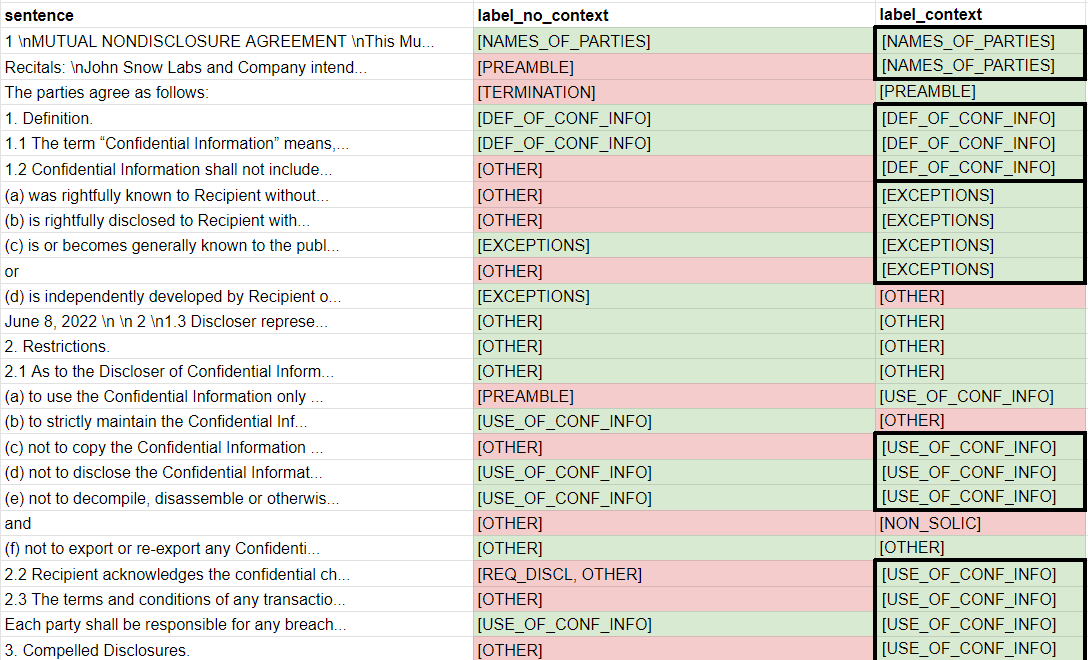

Although this is not a recipe you can use at any case, and highly depends on how your classifier was trained, it can really help to:
✅ Standardise blocks of predictions, capturing and grouping sentences together
✅ Carry out the meaning to the surroundings to resolve short sentences without much meaning

❌However, this does not come without a caveat. Sometimes, short sentences with no meaningful text may get affected by the surroundings.